In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

In [25]:
# source: https://www.amd.com/content/dam/amd/en/documents/instinct-tech-docs/data-sheets/amd-instinct-mi300x-data-sheet.pdf

PEAK_FP32_TFLOPS_MI300 = 163.4

In [26]:
NOTEBOOK_DIR = os.path.abspath('')
REPO_TOP_DIR = os.path.dirname(NOTEBOOK_DIR)
RESULTS_DIR = os.path.join(REPO_TOP_DIR, "results")

In [27]:
# Check if results directory exists and count JSON files
if os.path.exists(RESULTS_DIR):
    json_files = [f for f in os.listdir(RESULTS_DIR) if f.endswith('.json')]
    print(f"Found {len(json_files)} JSON files in {RESULTS_DIR}")
    print("\nJSON files:")
    for f in json_files:
        print(f"- {f}")
else:
    print(f"Results directory not found: {RESULTS_DIR}")


Found 7 JSON files in /root/Workspace/AMD-benchmarking-harness/results

JSON files:
- results_pytorch_config__8192x8192x8192_20250311_154948.json
- results_hip_blas_config__8192x8192x8192_20250311_155305.json
- results_hip_config_1d_blocked_matmul_8192x8192x8192_20250311_155549.json
- results_hip_config_basic_matmul_col_8192x8192x8192_20250311_155949.json
- results_triton_config__8192x8192x8192_20250311_161001.json
- results_hip_config_basic_matmul_row_8192x8192x8192_20250311_161454.json
- results_hip_config_blocked_matmul_8192x8192x8192_20250311_161606.json


In [28]:
# Function to flatten nested JSON structures
def flatten_json(nested_json, prefix=''):
    flattened = {}
    
    # Handle dictionaries - recurse into them
    if isinstance(nested_json, dict):
        for key, value in nested_json.items():
            if prefix:
                new_key = f"{prefix}_{key}"
            else:
                new_key = key
                
            # Recursively flatten if value is dict or list, otherwise add directly
            if isinstance(value, (dict, list)):
                flattened.update(flatten_json(value, new_key))
            else:
                flattened[new_key] = value
    
    # Handle lists - enumerate and recurse into items
    elif isinstance(nested_json, list):
        for i, item in enumerate(nested_json):
            # Create indexed key for list items
            new_key = f"{prefix}_{i}" if prefix else str(i)
            
            # Recursively flatten if item is dict or list, otherwise add directly
            if isinstance(item, (dict, list)):
                flattened.update(flatten_json(item, new_key))
            else:
                flattened[new_key] = item
    
    # Handle primitive values (unlikely at top level, but just in case)
    else:
        flattened[prefix] = nested_json
        
    return flattened


In [29]:

# Load and flatten all JSON files from the results directory
json_files = [f for f in os.listdir(RESULTS_DIR) if f.endswith('.json')]
flattened_data = []

for json_file in json_files:
    file_path = os.path.join(RESULTS_DIR, json_file)
    try:
        with open(file_path, 'r') as f:
            data = json.load(f)
            
            # Handle both dict and list JSON structures
            if isinstance(data, dict):
                flat_data = flatten_json(data)
                flat_data['source_file'] = json_file
                flattened_data.append(flat_data)
            elif isinstance(data, list):
                for i, item in enumerate(data):
                    if isinstance(item, dict):
                        flat_item = flatten_json(item)
                        flat_item['source_file'] = json_file
                        flat_item['item_index'] = i  # Keep track of item position in list
                        flattened_data.append(flat_item)
            
    except Exception as e:
        print(f"Error loading {json_file}: {e}")



In [30]:
# Create DataFrame from the flattened data
flat_df = pd.DataFrame(flattened_data)

# Display the first few rows and column names
print(f"Total columns: {len(flat_df.columns)}")
print(f"Column names: {', '.join(flat_df.columns[:10])}... (and {len(flat_df.columns)-10} more)")
flat_df.head()

Total columns: 19
Column names: kernel_type, kernel_name, matrix_dims_M, matrix_dims_N, matrix_dims_K, matrix_dims_alpha, matrix_dims_beta, parameters_num_warmup, parameters_num_iterations, timing_stats_mean... (and 9 more)


,kernel_type,kernel_name,matrix_dims_M,matrix_dims_N,matrix_dims_K,matrix_dims_alpha,matrix_dims_beta,parameters_num_warmup,parameters_num_iterations,timing_stats_mean,timing_stats_std,timing_stats_min,timing_stats_max,timing_stats_median,timing_stats_total_time,performance_tflops,timestamp,precision,source_file
0,pytorch,,8192,8192,8192,1.0,0.0,3,10,11.10,0.06,10.98,11.17,11.14,111.02,99.04,2025-03-11T15:49:48.511248,fp32,results_pytorch_config__8192x8192x8192_2025031...
1,hip_blas,,8192,8192,8192,1.0,0.0,3,10,12.26,0.35,11.61,12.76,12.27,122.61,89.68,2025-03-11T15:53:05.854313,fp32,results_hip_blas_config__8192x8192x8192_202503...
2,hip,1d_blocked_matmul,8192,8192,8192,1.0,0.0,3,10,49.61,0.44,48.81,50.03,49.84,496.06,22.16,2025-03-11T15:55:49.912220,fp32,results_hip_config_1d_blocked_matmul_8192x8192...
3,hip,basic_matmul_col,8192,8192,8192,1.0,0.0,3,10,276.32,2.91,268.69,280.09,276.77,2763.16,3.98,2025-03-11T15:59:49.927124,fp32,results_hip_config_basic_matmul_col_8192x8192x...
4,triton,,8192,8192,8192,1.0,0.0,3,10,12.71,0.13,12.57,12.96,12.68,127.13,86.49,2025-03-11T16:10:01.083302,fp32,results_triton_config__8192x8192x8192_20250311...


In [35]:
flat_df['tflops_ratio'] = flat_df['performance_tflops'] / PEAK_FP32_TFLOPS_MI300

In [37]:
flat_df

,kernel_type,kernel_name,matrix_dims_M,matrix_dims_N,matrix_dims_K,matrix_dims_alpha,matrix_dims_beta,parameters_num_warmup,parameters_num_iterations,timing_stats_mean,timing_stats_std,timing_stats_min,timing_stats_max,timing_stats_median,timing_stats_total_time,performance_tflops,timestamp,precision,source_file,tflops_ratio
0,pytorch,,8192,8192,8192,1.0,0.0,3,10,11.10,0.06,10.98,11.17,11.14,111.02,99.04,2025-03-11T15:49:48.511248,fp32,results_pytorch_config__8192x8192x8192_2025031...,0.606120
1,hip_blas,,8192,8192,8192,1.0,0.0,3,10,12.26,0.35,11.61,12.76,12.27,122.61,89.68,2025-03-11T15:53:05.854313,fp32,results_hip_blas_config__8192x8192x8192_202503...,0.548837
2,hip,1d_blocked_matmul,8192,8192,8192,1.0,0.0,3,10,49.61,0.44,48.81,50.03,49.84,496.06,22.16,2025-03-11T15:55:49.912220,fp32,results_hip_config_1d_blocked_matmul_8192x8192...,0.135618
3,hip,basic_matmul_col,8192,8192,8192,1.0,0.0,3,10,276.32,2.91,268.69,280.09,276.77,2763.16,3.98,2025-03-11T15:59:49.927124,fp32,results_hip_config_basic_matmul_col_8192x8192x...,0.024357
4,triton,,8192,8192,8192,1.0,0.0,3,10,12.71,0.13,12.57,12.96,12.68,127.13,86.49,2025-03-11T16:10:01.083302,fp32,results_triton_config__8192x8192x8192_20250311...,0.529315
5,hip,basic_matmul_row,8192,8192,8192,1.0,0.0,3,10,938.66,0.29,938.24,939.09,938.74,9386.58,1.17,2025-03-11T16:14:54.083265,fp32,results_hip_config_basic_matmul_row_8192x8192x...,0.007160
6,hip,blocked_matmul,8192,8192,8192,1.0,0.0,3,10,75.87,0.19,75.56,76.20,75.85,758.67,14.49,2025-03-11T16:16:06.623218,fp32,results_hip_config_blocked_matmul_8192x8192x81...,0.088678


### Plot

<Figure size 1600x1000 with 0 Axes>

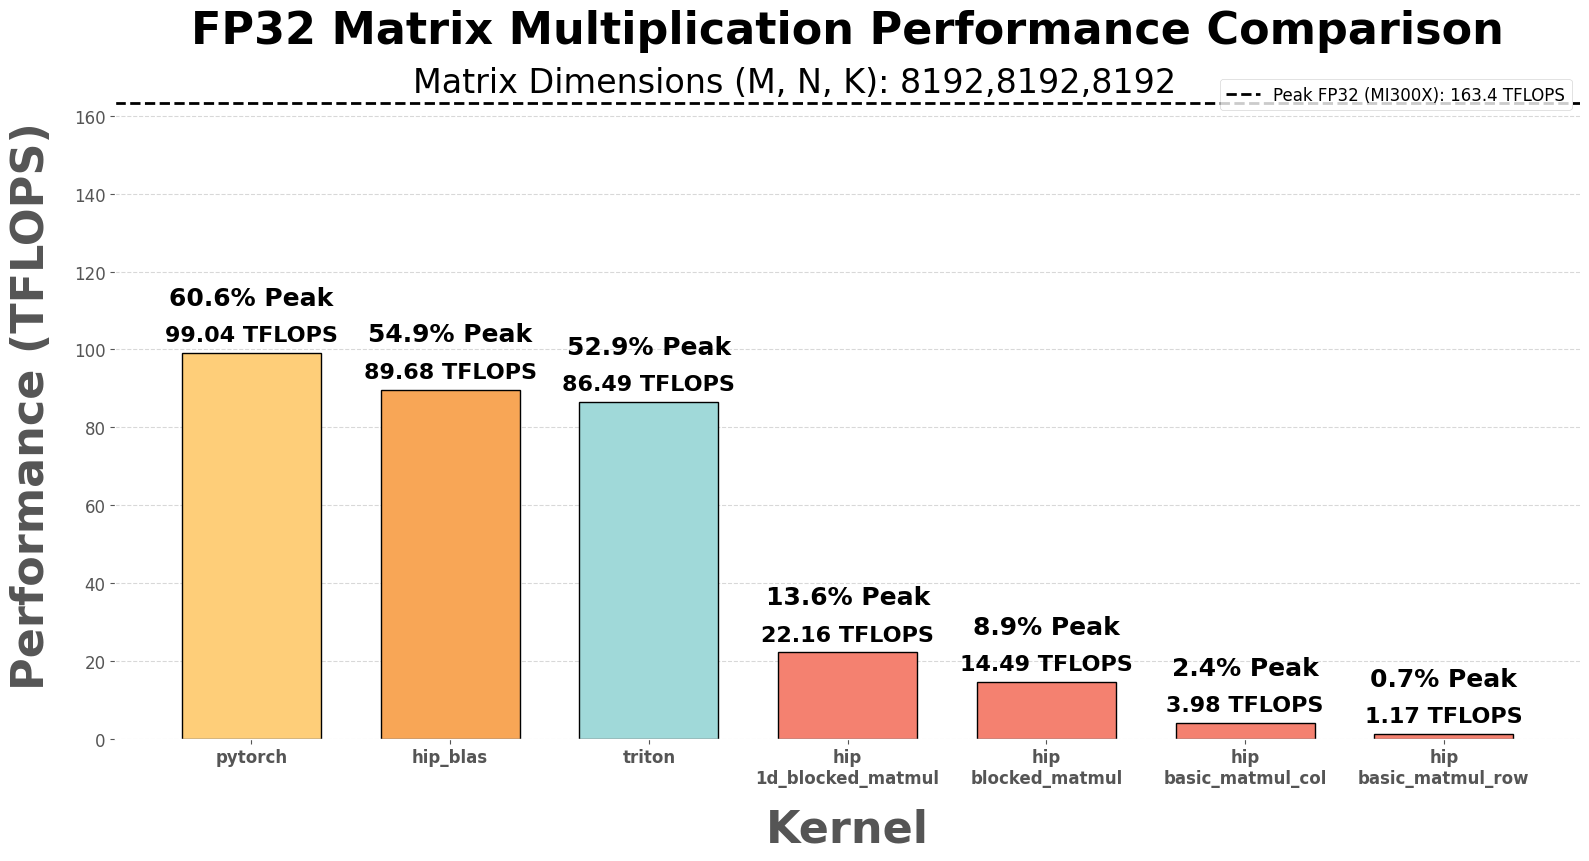

In [73]:
# Create a clean bar chart with specific colors
plt.figure(figsize=(16, 10))
plt.figure(figsize=(16, 10), facecolor='white')
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'

# Create x-axis labels combining kernel_type and kernel_name
x_labels = []
for i, row in flat_df.iterrows():
    if row['kernel_name']:
        x_labels.append(f"{row['kernel_type']}\n{row['kernel_name']}")
    else:
        x_labels.append(f"{row['kernel_type']}")

# Sort by TFLOPS performance (descending)
sorted_indices = flat_df['performance_tflops'].argsort()[::-1]
sorted_df = flat_df.iloc[sorted_indices]
sorted_labels = [x_labels[i] for i in sorted_indices]

# Color palette based on kernel_type as requested
color_map = {
    'pytorch': '#FECE79',   # Modern orange/amber
    'hip': '#F48170',       # Soft crimson red
    'hip_blas': '#F8A656',  # Deep ruby red
    'triton': '#A0D9D9'     # Modern slate blue
}

# Assign colors based on kernel_type
bar_colors = [color_map.get(sorted_df['kernel_type'].iloc[i], '#888888') for i in range(len(sorted_df))]

# Create the bar chart with clean styling
bars = plt.bar(sorted_labels, sorted_df['performance_tflops'], 
              color=bar_colors, edgecolor='black', linewidth=1,
              width=0.7)

# Add data values on top of each bar
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 2,
             f'{height:.2f} TFLOPS',
             ha='center', va='bottom', rotation=0, fontsize=16, fontweight='bold')

# Add the peak performance horizontal line
plt.axhline(y=PEAK_FP32_TFLOPS_MI300, color='black', linestyle='--', linewidth=2, 
            label=f'Peak FP32 (MI300X): {PEAK_FP32_TFLOPS_MI300} TFLOPS')

# Add percentage labels with clean positioning
for i, bar in enumerate(bars):
    height = bar.get_height()
    percentage = sorted_df['tflops_ratio'].iloc[i] * 100
    
    plt.annotate(f'{percentage:.1f}% Peak', 
                xy=(bar.get_x() + bar.get_width()/2, height + 10),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=18, fontweight='bold')

plt.xticks(fontsize=24, fontweight='bold')
# Customize the chart with better typography
plt.xlabel('Kernel', fontsize=32, fontweight='bold', labelpad=15)
plt.ylabel('Performance (TFLOPS)', fontsize=32, fontweight='bold', labelpad=15)
plt.title('FP32 Matrix Multiplication Performance Comparison', 
          fontsize=32, fontweight='bold', pad=20)

# Add a subtitle with matrix dimensions
plt.suptitle(f'Matrix Dimensions (M, N, K): {flat_df["matrix_dims_M"].iloc[0]},{flat_df["matrix_dims_N"].iloc[0]},{flat_df["matrix_dims_K"].iloc[0]}', 
             fontsize=24, y=0.83)

# Clean legend 
legend = plt.legend(loc='upper right', frameon=True, fontsize=12)

# Customize grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.3, color='gray')

# Remove top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Enhance tick labels
plt.xticks(fontsize=12, fontweight='bold')
plt.yticks(fontsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for title

plt.show()